In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import csv

from scipy.stats import randint
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import mean_squared_error,r2_score

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical,np_utils
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

import itertools
from keras import backend as f
from keras.layers import LSTM, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd "/content/drive/My Drive/Colab Notebooks/REDES_NEURONALES_SERIES_TEMPORALES"

/content/drive/My Drive/Colab Notebooks/REDES_NEURONALES_SERIES_TEMPORALES


In [24]:
train = pd.read_csv('data/train.txt',sep=';',index_col=0)
test = pd.read_csv('data/test.txt',sep=';',index_col=0)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [25]:
train = train.set_index('Fecha_Hora')
train.head()

,Poder_Reactivo_Global,Voltaje,Intensidad_Global,Medida_1,Medida_2,Medida_3,Poder_Activo_Global
Fecha_Hora,,,,,,,
16/12/2006 17:24:00,0.418,234.840,18.400,0.000,1.000,17.0,4.216
16/12/2006 17:25:00,0.436,233.630,23.000,0.000,1.000,16.0,5.360
16/12/2006 17:26:00,0.498,233.290,23.000,0.000,2.000,17.0,5.374
16/12/2006 17:27:00,0.502,233.740,23.000,0.000,1.000,17.0,5.388
16/12/2006 17:28:00,0.528,235.680,15.800,0.000,1.000,17.0,3.666


In [26]:
test['Fecha_Hora'] = test['Fecha'] + ' ' + test['Hora']
test = test.drop('Fecha', axis = 1)
test = test.drop('Hora', axis = 1)
test = test[['Fecha_Hora','Poder_Reactivo_Global', 'Voltaje', 'Intensidad_Global', 'Medida_1',
       'Medida_2', 'Medida_3']]
test = test.set_index('Fecha_Hora')
test.head()

,Poder_Reactivo_Global,Voltaje,Intensidad_Global,Medida_1,Medida_2,Medida_3
Fecha_Hora,,,,,,
20/11/2010 19:03:00,0.328,228.26,23.6,34.0,1.0,16.0
20/11/2010 19:04:00,0.326,228.57,23.2,36.0,2.0,16.0
20/11/2010 19:05:00,0.350,229.09,23.8,38.0,1.0,16.0
20/11/2010 19:06:00,0.432,231.83,15.2,8.0,2.0,17.0
20/11/2010 19:07:00,0.442,232.69,15.4,3.0,2.0,17.0


In [27]:
dataset = pd.concat([train,test])
dataset.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Intensidad_Global,Medida_1,Medida_2,Medida_3,Poder_Activo_Global,Poder_Reactivo_Global,Voltaje
Fecha_Hora,,,,,,,
16/12/2006 17:24:00,18.400,0.000,1.000,17.0,4.216,0.418,234.840
16/12/2006 17:25:00,23.000,0.000,1.000,16.0,5.360,0.436,233.630
16/12/2006 17:26:00,23.000,0.000,2.000,17.0,5.374,0.498,233.290
16/12/2006 17:27:00,23.000,0.000,1.000,17.0,5.388,0.502,233.740
16/12/2006 17:28:00,15.800,0.000,1.000,17.0,3.666,0.528,235.680


In [0]:
dataset = dataset[['Intensidad_Global', 'Medida_1', 'Medida_2', 'Medida_3', 'Poder_Reactivo_Global', 'Voltaje',
       'Poder_Activo_Global']]
dataset = dataset.replace('?',np.nan)
set_train = dataset.iloc[:-8760,:]
set_test = dataset.iloc[-8760:,:]

In [0]:
set_train = set_train.apply(pd.to_numeric)
for i in range(0,7):
  set_train.iloc[:,i]=set_train.iloc[:,i].fillna(set_train.iloc[:,i].mean())

In [35]:
set_train.tail()

,Intensidad_Global,Medida_1,Medida_2,Medida_3,Poder_Reactivo_Global,Voltaje,Poder_Activo_Global
Fecha_Hora,,,,,,,
20/11/2010 18:58:00,20.2,23.0,5.0,17.0,0.254,230.55,4.526
20/11/2010 18:59:00,20.0,23.0,5.0,16.0,0.274,229.74,4.478
20/11/2010 19:00:00,19.8,21.0,4.0,16.0,0.248,229.32,4.422
20/11/2010 19:01:00,19.6,23.0,5.0,16.0,0.270,229.29,4.366
20/11/2010 19:02:00,19.4,21.0,2.0,16.0,0.308,228.87,4.284


In [0]:
# CONVIERTIENDO A ARRAY
values = set_train.values
# Reducimos la data de entrada para una mayor velocidad
values = values[-20000:,:]

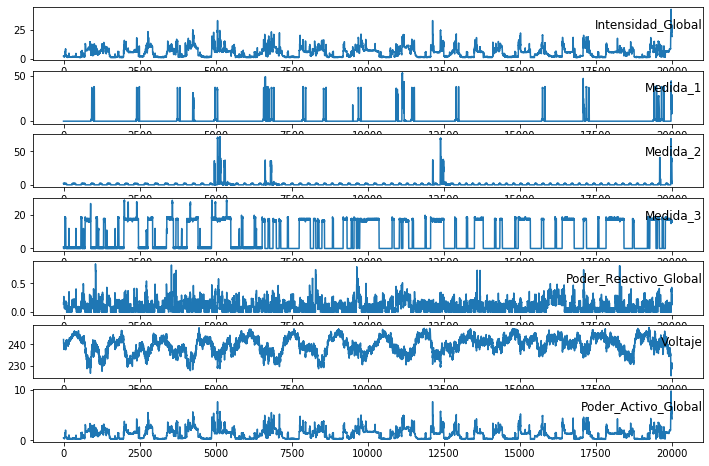

In [40]:
# Ploteamos el comportamiento de las features
groups = [0,1,2,3,4,5,6]
i = 1
plt.figure(figsize=(12,8))
for group in groups:
  plt.subplot(len(groups),1,i)
  plt.plot(values[:,group])
  plt.title(dataset.columns[group],y=0.5,loc='right')
  i+=1
plt.show()

In [0]:
# FUNCION PARA CONVERTIR A DATA SUPERVISADA
def series_to_supervised(data,n_in=1,n_out=1,dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols,names = list(),list()

  for i in range(n_in,0,-1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)'% (j+1,i)) for j in range(n_vars)]
  
  for i in range(0,n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)'% (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)'%(j+1,i)) for j in range(n_vars)]
    
  agg = pd.concat(cols,axis=1)
  agg.columns = names

  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [0]:
# Escalamiento de la data
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [134]:
# Generamos el dataframe necesario para el entrenamiento
n_min = 60 #Numero de minutos que se tomaran como indicador
n_features = 6 #Cantidad de caracteristicas a considerar
reframed = series_to_supervised(scaled,n_min,1)
# Ya que el target como si mismo no sera considerado como feature, eliminamos dichas columnas
for i in range(1,n_min+1):
  reframed.drop(['var7(t-%d)'% (i)],axis=1,inplace=True)
values = reframed.values
reframed.head()

,var1(t-60),var2(t-60),var3(t-60),var4(t-60),var5(t-60),var6(t-60),var1(t-59),var2(t-59),var3(t-59),var4(t-59),var5(t-59),var6(t-59),var1(t-58),var2(t-58),var3(t-58),var4(t-58),var5(t-58),var6(t-58),var1(t-57),var2(t-57),var3(t-57),var4(t-57),var5(t-57),var6(t-57),var1(t-56),var2(t-56),var3(t-56),var4(t-56),var5(t-56),var6(t-56),var1(t-55),var2(t-55),var3(t-55),var4(t-55),var5(t-55),var6(t-55),var1(t-54),var2(t-54),var3(t-54),var4(t-54),...,var4(t-6),var5(t-6),var6(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
60,0.638095,0.264151,0.486111,0.586207,0.447619,0.205162,0.647619,0.283019,0.500000,0.551724,0.466667,0.142412,0.666667,0.245283,0.555556,0.551724,0.511905,0.138407,0.652381,0.245283,0.541667,0.551724,0.366667,0.175345,0.604762,0.169811,0.555556,0.551724,0.292857,0.186026,0.580952,0.150943,0.555556,0.551724,0.264286,0.218959,0.628571,0.396226,0.472222,0.586207,...,0.586207,0.380952,0.456164,0.238095,0.000000,0.027778,0.586207,0.378571,0.396084,0.238095,0.000000,0.013889,0.586207,0.378571,0.425901,0.242857,0.018868,0.027778,0.586207,0.380952,0.434802,0.247619,0.000000,0.013889,0.586207,0.440476,0.460169,0.252381,0.000000,0.013889,0.586207,0.504762,0.512239,0.252381,0.000000,0.013889,0.586207,0.500000,0.503783,0.543901
61,0.647619,0.283019,0.500000,0.551724,0.466667,0.142412,0.666667,0.245283,0.555556,0.551724,0.511905,0.138407,0.652381,0.245283,0.541667,0.551724,0.366667,0.175345,0.604762,0.169811,0.555556,0.551724,0.292857,0.186026,0.580952,0.150943,0.555556,0.551724,0.264286,0.218959,0.628571,0.396226,0.472222,0.586207,0.207143,0.155763,0.614286,0.415094,0.416667,0.551724,...,0.586207,0.378571,0.396084,0.238095,0.000000,0.013889,0.586207,0.378571,0.425901,0.242857,0.018868,0.027778,0.586207,0.380952,0.434802,0.247619,0.000000,0.013889,0.586207,0.440476,0.460169,0.252381,0.000000,0.013889,0.586207,0.504762,0.512239,0.252381,0.000000,0.013889,0.586207,0.500000,0.503783,0.257143,0.000000,0.027778,0.620690,0.507143,0.516689,0.543901
62,0.666667,0.245283,0.555556,0.551724,0.511905,0.138407,0.652381,0.245283,0.541667,0.551724,0.366667,0.175345,0.604762,0.169811,0.555556,0.551724,0.292857,0.186026,0.580952,0.150943,0.555556,0.551724,0.264286,0.218959,0.628571,0.396226,0.472222,0.586207,0.207143,0.155763,0.614286,0.415094,0.416667,0.551724,0.171429,0.220739,0.528571,0.396226,0.250000,0.551724,...,0.586207,0.378571,0.425901,0.242857,0.018868,0.027778,0.586207,0.380952,0.434802,0.247619,0.000000,0.013889,0.586207,0.440476,0.460169,0.252381,0.000000,0.013889,0.586207,0.504762,0.512239,0.252381,0.000000,0.013889,0.586207,0.500000,0.503783,0.257143,0.000000,0.027778,0.620690,0.507143,0.516689,0.252381,0.018868,0.013889,0.586207,0.495238,0.484201,0.543901
63,0.652381,0.245283,0.541667,0.551724,0.366667,0.175345,0.604762,0.169811,0.555556,0.551724,0.292857,0.186026,0.580952,0.150943,0.555556,0.551724,0.264286,0.218959,0.628571,0.396226,0.472222,0.586207,0.207143,0.155763,0.614286,0.415094,0.416667,0.551724,0.171429,0.220739,0.528571,0.396226,0.250000,0.551724,0.197619,0.255897,0.647619,0.320755,0.472222,0.551724,...,0.586207,0.380952,0.434802,0.247619,0.000000,0.013889,0.586207,0.440476,0.460169,0.252381,0.000000,0.013889,0.586207,0.504762,0.512239,0.252381,0.000000,0.013889,0.586207,0.500000,0.503783,0.257143,0.000000,0.027778,0.620690,0.507143,0.516689,0.252381,0.018868,0.013889,0.586207,0.495238,0.484201,0.252381,0.000000,0.027778,0.586207,0.504762,0.510903,0.543901
64,0.604762,0.169811,0.555556,0.551724,0.292857,0.186026,0.580952,0.150943,0.555556,0.551724,0.264286,0.218959,0.628571,0.396226,0.472222,0.586207,0.207143,0.155763,0.614286,0.415094,0.416667,0.551724,0.171429,0.220739,0.528571,0.396226,0.250000,0.551724,0.1976

In [135]:
# Partimos el set_train en train y val
n_train_min = int(values.shape[0]*3/4) # Valor de corte
train = values[:n_train_min,:]
val = values[n_train_min:,:]

n_obs = n_min*n_features # numero de elementos de la matriz de data a considerar en cada prediccion
train_X,train_y = train[:,:n_obs],train[:,-1]
val_X,val_y = val[:,:n_obs],val[:,-1]
print(train_X.shape,len(train_X),train_y.shape)

(6540, 360) 6540 (6540,)


In [136]:
# REDIMENSIONANDO PARA LA ENTRADA A LA RED LSTM
train_X = train_X.reshape((train_X.shape[0],n_min,n_features))
val_X = val_X.reshape((val_X.shape[0],n_min,n_features))
print(train_X.shape,train_y.shape,val_X.shape,val_y.shape)

(6540, 60, 6) (6540,) (2180, 60, 6) (2180,)


In [0]:
# LOSS
#def root_mean_squared_error(y_true, y_pred):
#        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [0]:
# DISEÑO DEL MODELO
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(Dropout(0.2))

#model.add(LSTM(50,return_sequences=True))
#model.add(Dropout(0.2))

#model.add(LSTM(50,return_sequences=True))
#model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer = 'adam')

In [138]:
history = model.fit(train_X,train_y,epochs=50,batch_size=72,validation_data = (val_X,val_y),verbose=2,shuffle = False)

Train on 6540 samples, validate on 2180 samples
Epoch 1/50
 - 19s - loss: 0.0194 - val_loss: 0.0016
Epoch 2/50
 - 17s - loss: 0.0069 - val_loss: 0.0012
Epoch 3/50
 - 17s - loss: 0.0044 - val_loss: 6.6953e-04
Epoch 4/50
 - 17s - loss: 0.0034 - val_loss: 5.2066e-04
Epoch 5/50
 - 17s - loss: 0.0026 - val_loss: 2.9001e-04
Epoch 6/50
 - 17s - loss: 0.0022 - val_loss: 1.4120e-04
Epoch 7/50
 - 18s - loss: 0.0020 - val_loss: 1.4125e-04
Epoch 8/50
 - 17s - loss: 0.0017 - val_loss: 1.2098e-04
Epoch 9/50
 - 18s - loss: 0.0016 - val_loss: 1.3482e-04
Epoch 10/50
 - 19s - loss: 0.0015 - val_loss: 1.9192e-04
Epoch 11/50
 - 18s - loss: 0.0013 - val_loss: 5.9759e-05
Epoch 12/50
 - 18s - loss: 0.0012 - val_loss: 2.8724e-05
Epoch 13/50
 - 18s - loss: 0.0011 - val_loss: 3.1050e-05
Epoch 14/50
 - 18s - loss: 0.0011 - val_loss: 2.9861e-05
Epoch 15/50
 - 18s - loss: 0.0010 - val_loss: 8.9315e-06
Epoch 16/50
 - 18s - loss: 9.8687e-04 - val_loss: 1.2310e-05
Epoch 17/50
 - 19s - loss: 9.4882e-04 - val_loss: 8.8

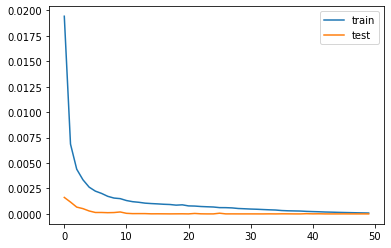

In [139]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

ValueError: ignored

In [140]:
# make a prediction
val_X = val_X.reshape((val_X.shape[0],n_min,n_features))
yhat = model.predict(val_X)
val_X = val_X.reshape((val_X.shape[0], n_min*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, val_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
val_y = val_y.reshape((len(val_y), 1))
inv_y = np.concatenate((val_y, val_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.040


In [0]:
# PREPROCESANDO EL TEST
set_test = dataset.iloc[-8780:,:]
set_test = set_test.apply(pd.to_numeric)
for i in range(0,7):
  set_test.iloc[:,i]=set_test.iloc[:,i].fillna(set_test.iloc[:,i].mean())
  
test_values = set_test.values

# Escalamiento de la data test
scaled_test = scaler.transform(test_values)

In [142]:
# Generamos el dataframe necesario para el testeo
n_min = 20 #Numero de minutos que se tomaran como indicador
n_features = 6 #Cantidad de caracteristicas a considerar
reframed_test = series_to_supervised(scaled_test,n_min,1)
# Ya que el target como si mismo no sera considerado como feature, eliminamos dichas columnas
for i in range(1,n_min+1):
  reframed_test.drop(['var7(t-%d)'% (i)],axis=1,inplace=True)
values_test = reframed_test.values
reframed_test.head()

,var1(t-20),var2(t-20),var3(t-20),var4(t-20),var5(t-20),var6(t-20),var1(t-19),var2(t-19),var3(t-19),var4(t-19),var5(t-19),var6(t-19),var1(t-18),var2(t-18),var3(t-18),var4(t-18),var5(t-18),var6(t-18),var1(t-17),var2(t-17),var3(t-17),var4(t-17),var5(t-17),var6(t-17),var1(t-16),var2(t-16),var3(t-16),var4(t-16),var5(t-16),var6(t-16),var1(t-15),var2(t-15),var3(t-15),var4(t-15),var5(t-15),var6(t-15),var1(t-14),var2(t-14),var3(t-14),var4(t-14),...,var4(t-6),var5(t-6),var6(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
20,0.638095,0.264151,0.486111,0.586207,0.447619,0.205162,0.647619,0.283019,0.500000,0.551724,0.466667,0.142412,0.666667,0.245283,0.555556,0.551724,0.511905,0.138407,0.652381,0.245283,0.541667,0.551724,0.366667,0.175345,0.604762,0.169811,0.555556,0.551724,0.292857,0.186026,0.580952,0.150943,0.555556,0.551724,0.264286,0.218959,0.628571,0.396226,0.472222,0.586207,...,0.551724,0.335714,0.263907,0.457143,0.433962,0.069444,0.586207,0.302381,0.232755,0.452381,0.433962,0.069444,0.551724,0.326190,0.196707,0.447619,0.396226,0.055556,0.551724,0.295238,0.178015,0.442857,0.433962,0.069444,0.551724,0.321429,0.176680,0.438095,0.396226,0.027778,0.551724,0.366667,0.157988,0.538095,0.641509,0.013889,0.551724,0.390476,0.130841,0.543901
21,0.647619,0.283019,0.500000,0.551724,0.466667,0.142412,0.666667,0.245283,0.555556,0.551724,0.511905,0.138407,0.652381,0.245283,0.541667,0.551724,0.366667,0.175345,0.604762,0.169811,0.555556,0.551724,0.292857,0.186026,0.580952,0.150943,0.555556,0.551724,0.264286,0.218959,0.628571,0.396226,0.472222,0.586207,0.207143,0.155763,0.614286,0.415094,0.416667,0.551724,...,0.586207,0.302381,0.232755,0.452381,0.433962,0.069444,0.551724,0.326190,0.196707,0.447619,0.396226,0.055556,0.551724,0.295238,0.178015,0.442857,0.433962,0.069444,0.551724,0.321429,0.176680,0.438095,0.396226,0.027778,0.551724,0.366667,0.157988,0.538095,0.641509,0.013889,0.551724,0.390476,0.130841,0.528571,0.679245,0.027778,0.551724,0.388095,0.144637,0.543901
22,0.666667,0.245283,0.555556,0.551724,0.511905,0.138407,0.652381,0.245283,0.541667,0.551724,0.366667,0.175345,0.604762,0.169811,0.555556,0.551724,0.292857,0.186026,0.580952,0.150943,0.555556,0.551724,0.264286,0.218959,0.628571,0.396226,0.472222,0.586207,0.207143,0.155763,0.614286,0.415094,0.416667,0.551724,0.171429,0.220739,0.528571,0.396226,0.250000,0.551724,...,0.551724,0.326190,0.196707,0.447619,0.396226,0.055556,0.551724,0.295238,0.178015,0.442857,0.433962,0.069444,0.551724,0.321429,0.176680,0.438095,0.396226,0.027778,0.551724,0.366667,0.157988,0.538095,0.641509,0.013889,0.551724,0.390476,0.130841,0.528571,0.679245,0.027778,0.551724,0.388095,0.144637,0.542857,0.716981,0.013889,0.551724,0.416667,0.167779,0.543901
23,0.652381,0.245283,0.541667,0.551724,0.366667,0.175345,0.604762,0.169811,0.555556,0.551724,0.292857,0.186026,0.580952,0.150943,0.555556,0.551724,0.264286,0.218959,0.628571,0.396226,0.472222,0.586207,0.207143,0.155763,0.614286,0.415094,0.416667,0.551724,0.171429,0.220739,0.528571,0.396226,0.250000,0.551724,0.197619,0.255897,0.647619,0.320755,0.472222,0.551724,...,0.551724,0.295238,0.178015,0.442857,0.433962,0.069444,0.551724,0.321429,0.176680,0.438095,0.396226,0.027778,0.551724,0.366667,0.157988,0.538095,0.641509,0.013889,0.551724,0.390476,0.130841,0.528571,0.679245,0.027778,0.551724,0.388095,0.144637,0.542857,0.716981,0.013889,0.551724,0.416667,0.167779,0.338095,0.150943,0.027778,0.586207,0.514286,0.289720,0.543901
24,0.604762,0.169811,0.555556,0.551724,0.292857,0.186026,0.580952,0.150943,0.555556,0.551724,0.264286,0.218959,0.628571,0.396226,0.472222,0.586207,0.207143,0.155763,0.614286,0.415094,0.416667,0.551724,0.171429,0.220739,0.528571,0.396226,0.250000,0.551724,0.1976

In [0]:
# Obtenemos nuestra data de interes
n_obs = n_min*n_features
test_X = values_test[:,:n_obs]
# Redimensionamos
test_X = test_X.reshape((test_X.shape[0],n_min,n_features))

In [144]:
# Prediccion
yhat = model.predict(test_X)

ValueError: ignored

In [0]:
# POST PROCESADO PARA DESESCALAR
test_X = test_X.reshape((test_X.shape[0],n_obs))

In [146]:
# Invertimos escalado
inv_yhat = np.concatenate((yhat,test_X[:,-6:]),axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

ValueError: ignored

In [126]:
inv_yhat

array([23.80587661, 23.80783927, 23.80968928, ..., 23.83837819,
       23.83805776, 23.83777487])

In [0]:
prediction = pd.DataFrame(inv_yhat)

In [0]:
set_test = dataset.iloc[-8760:,:]

In [129]:
set_test['Poder_Activo_Global'] = inv_yhat

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
enviar = set_test[['Poder_Activo_Global']]

In [131]:
enviar['Fecha_Hora'] = enviar.index

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [132]:
enviar = enviar.reset_index(drop=True)
enviar = enviar[['Fecha_Hora', 'Poder_Activo_Global']]
enviar

,Fecha_Hora,Poder_Activo_Global
0,20/11/2010 19:03:00,23.805877
1,20/11/2010 19:04:00,23.807839
2,20/11/2010 19:05:00,23.809689
3,20/11/2010 19:06:00,23.811577
4,20/11/2010 19:07:00,23.813975
...,...,...
8755,26/11/2010 20:58:00,23.839032
8756,26/11/2010 20:59:00,23.838714
8757,26/11/2010 21:00:00,23.838378
8758,26/11/2010 21:01:00,23.838058


In [0]:
enviar.to_csv('Output.csv',index=False)